In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from source.data import DataLoader, PreprocessingPipelineBuilder, DataExplorer, DataPreparer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [2]:
loader = DataLoader()
mexwell_set = {"link":"mexwell/fake-reviews-dataset", "filename":"fake reviews dataset.csv"}
try:
    mexwell_df = loader.load_from_kaggle(**mexwell_set)
    print(f"Данные успешно загружены из Kaggle.")
    print(f"Исходная размерность DataFrame: {mexwell_df.shape}")
    print("\nПервые 5 строк данных:")
    display(mexwell_df.head()) 
except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")
    mexwell_df = None


../data\mexwell\fake-reviews-dataset\fake reviews dataset.csv
Данные успешно загружены из Kaggle.
Исходная размерность DataFrame: (40432, 4)

Первые 5 строк данных:


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [3]:
explorer = DataExplorer(mexwell_df)
explorer.print_summary(text_column="text_", label_column="label", rating_column="rating")


СВОДКА ПО ДАННЫМ
Размерность данных: (40432, 4)
Количество колонок: 4
Колонки: category, rating, label, text_

Пропущенные значения отсутствуют

АНАЛИЗ ТЕКСТА:
  Длина текста - мин: 24, макс: 2827, среднее: 351.27
  Топ-5 слов: the(157256), a(96886), i(96841), and(87616), it(68590)

РАСПРЕДЕЛЕНИЕ РЕЙТИНГОВ:
  1.0: 2155 (5.3%)
  2.0: 1967 (4.9%)
  3.0: 3786 (9.4%)
  4.0: 7965 (19.7%)
  5.0: 24559 (60.7%)

РЕЙТИНГИ ПО МЕТКАМ (%):
label      CG     OR  Всего
rating                     
1.0      5.26   5.40   5.33
2.0      4.76   4.97   4.86
3.0      9.66   9.07   9.36
4.0     19.39  20.01  19.70
5.0     60.94  60.55  60.74

РАСПРЕДЕЛЕНИЕ МЕТОК:
  CG: 20216 (50.0%)
  OR: 20216 (50.0%)



In [4]:
preparer = DataPreparer(mexwell_df.copy())
preparer.handle_missing_values(strategy='drop', columns=['text_', 'label'])
preparer.drop_duplicates(subset=['text_', 'label'])
preparer.encode_labels(label_column='label')
label_mapping = preparer.get_label_mapping()
df_prepared = preparer.get_result()
display(df_prepared.head())

Encoding labels in 'label'. Mapping created: {'CG': 0, 'OR': 1}


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,0,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,0,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,0,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,0,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,0,Very nice set. Good quality. We have had the s...


In [5]:
X = df_prepared[['text_']] 
y = df_prepared['label']
X_train_df, X_test_df, y_train, y_test = train_test_split(
        X, y,
        test_size=0.25,
        random_state=42, 
    )

In [6]:
from source.data.augmentation import TextAugmenter
print(f"Размер исходной обучающей выборки: {len(X_train_df)}")
print(f"Размер тестовой выборки: {len(X_test_df)}")

augmenter = TextAugmenter()
augmented_texts = []
augmented_labels = []
num_augmentations_per_sample = 1
for index, row in X_train_df.iterrows():
    original_text = row['text_']
    original_label = y_train.loc[index]
    new_texts = augmenter.augment_text(original_text, num_aug=num_augmentations_per_sample)
    
    augmented_texts.extend(new_texts)
    augmented_labels.extend([original_label] * len(new_texts))

print(f"Сгенерировано {len(augmented_texts)} новых примеров.")

if augmented_texts:
    augmented_X_df = pd.DataFrame(augmented_texts, columns=['text_'])
    augmented_y_s = pd.Series(augmented_labels, name='label')
    X_train_augmented = pd.concat([X_train_df, augmented_X_df], ignore_index=True)
    y_train_augmented = pd.concat([y_train, augmented_y_s], ignore_index=True)
    
    print("Аугментация завершена.")
    print(f"Новый размер обучающей выборки (с аугментацией): {len(X_train_augmented)}")
else:
    print("Аугментация не сгенерировала новых данных. Используется исходная выборка.")
    X_train_augmented = X_train_df
    y_train_augmented = y_train


NLTK data 'wordnet' not found. Downloading...
NLTK data 'omw-1.4' not found. Downloading...
Размер исходной обучающей выборки: 30309
Размер тестовой выборки: 10103


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Сгенерировано 30308 новых примеров.
Аугментация завершена.
Новый размер обучающей выборки (с аугментацией): 60617


In [7]:
pipeline_builder = PreprocessingPipelineBuilder(df_prepared)
cleaning_methods = [
        'lower',              # Приведение к нижнему регистру
        'remove_punctuation', # Удаление знаков препинания
        'remove_numbers',     # Удаление чисел
        'remove_whitespace',  # Сжатие пробелов
        'remove_stopwords'    # Удаление стоп-слов
    ]


In [8]:
text_preprocessing_pipeline = pipeline_builder.build_text_preprocessing_pipeline(
            text_column='text_', 
            vectorizer_method='tfidf',
            clean_text_methods=cleaning_methods,
            clean_text_stopwords_lang='english', 
            clean_text_lemmatize=True,    
            clean_text_stem=False,         
            max_features=5000,   # Ограничение на количество признаков (слов/н-грам)
            min_df=2,            # Игнорировать термины, которые встречаются менее чем в 2 документах
            max_df=0.95,         # Игнорировать термины, которые встречаются более чем в 95% документов
            ngram_range=(1, 2)   # Учитывать унарные и биграммы
        )


Building text preprocessing pipeline for column 'text_'...
Text preprocessing pipeline built.


In [9]:
text_preprocessing_pipeline.fit(X_train_augmented, y_train_augmented)


,steps,"[('text_cleaner', ...), ('vectorizer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,text_column,'text_'
,methods,"['lower', 'remove_punctuation', ...]"
,stop_words_lang,'english'
,lemmatize,True
,stem,False
,input,'content'
,encoding,'utf-8'


In [10]:
X_train_vectorized = text_preprocessing_pipeline.transform(X_train_df)
X_test_vectorized = text_preprocessing_pipeline.transform(X_test_df)
fitted_vectorizer = text_preprocessing_pipeline.named_steps['vectorizer']


In [11]:
from source.models.baseline_models import BaselineModelTrainer
trainer = BaselineModelTrainer()
supported_models = trainer.get_supported_models()
print("\nПоддерживаемые модели в BaselineModelTrainer:")
display(supported_models)


Поддерживаемые модели в BaselineModelTrainer:


['logistic_regression', 'naive_bayes', 'linear_svc']

In [12]:
target_names = None
results = {} 
if 'label_mapping' in locals() and label_mapping:
     reverse_label_mapping = {v: k for k, v in label_mapping.items()}
     all_encoded_labels = sorted(list(set(y_train.tolist() + y_test.tolist())))
     try:
         target_names = [reverse_label_mapping[i] for i in all_encoded_labels]
         print(f"Используются имена классов из маппинга: {target_names}")
     except KeyError:
         print("Предупреждение: Некоторые закодированные метки не найдены в label_mapping. Используются числовые метки по умолчанию.")
         target_names = None 

Используются имена классов из маппинга: ['CG', 'OR']


In [13]:
import lightgbm as lgb
from sklearn.metrics import classification_report
lgbm_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
lgbm_model.fit(X_train_vectorized, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_vectorized)
print("\nОтчет по классификации для LightGBM:")
report_lgbm = classification_report(y_test, y_pred_lgbm, target_names=target_names, output_dict=True)
results['lightgbm'] = report_lgbm
print(classification_report(y_test, y_pred_lgbm, target_names=target_names))

[LightGBM] [Info] Number of positive: 15205, number of negative: 15104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217228
[LightGBM] [Info] Number of data points in the train set: 30309, number of used features: 4885
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Отчет по классификации для LightGBM:
              precision    recall  f1-score   support

          CG       0.88      0.85      0.86      5093
          OR       0.85      0.88      0.87      5010

    accuracy                           0.86     10103
   macro avg       0.87      0.86      0.86     10103
weighted avg       0.87      0.86      0.86     10103



N:\worktry\fake_reviews_detection\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


N:\worktry\fake_reviews_detection\venv\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
N:\worktry\fake_reviews_detection\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
N:\worktry\fake_reviews_detection\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
N:\worktry\fake_reviews_detection\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
N:\worktry\fake_reviews_detection\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not h

--- Отчет по классификации для исходного LightGBM ---
              precision    recall  f1-score   support

          CG       0.88      0.85      0.86      5093
          OR       0.85      0.88      0.87      5010

    accuracy                           0.86     10103
   macro avg       0.87      0.86      0.86     10103
weighted avg       0.87      0.86      0.86     10103


--- Отчет по классификации для калиброванного LightGBM ---
              precision    recall  f1-score   support

          CG       0.87      0.86      0.86      5093
          OR       0.86      0.87      0.86      5010

    accuracy                           0.86     10103
   macro avg       0.86      0.86      0.86     10103
weighted avg       0.86      0.86      0.86     10103


--- Визуализация калибровочных кривых ---


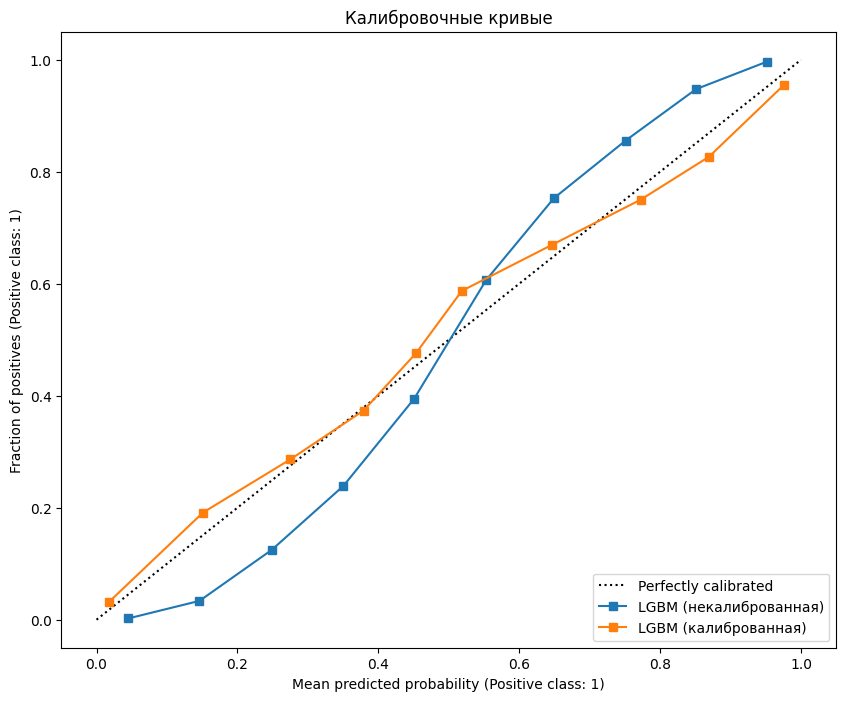

In [23]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

base_model = lgbm_model
calibrated_model = CalibratedClassifierCV(
    base_model,
    method='isotonic',
    cv='prefit'
)
calibrated_model.fit(X_train_vectorized, y_train)
y_pred_lgbm = base_model.predict(X_test_vectorized)
y_pred_calibrated = calibrated_model.predict(X_test_vectorized)
print("--- Отчет по классификации для исходного LightGBM ---")
print(classification_report(y_test, y_pred_lgbm, target_names=target_names))

print("\n--- Отчет по классификации для калиброванного LightGBM ---")
print(classification_report(y_test, y_pred_calibrated, target_names=target_names))

print("\n--- Визуализация калибровочных кривых ---")
fig, ax = plt.subplots(figsize=(10, 8))

display1 = CalibrationDisplay.from_estimator(
    base_model, X_test_vectorized, y_test, n_bins=10, name="LGBM (некалиброванная)", ax=ax
)
display2 = CalibrationDisplay.from_estimator(
    calibrated_model, X_test_vectorized, y_test, n_bins=10, name="LGBM (калиброванная)", ax=ax
)
plt.title("Калибровочные кривые")
plt.show()

Проверка гипотеза с LLM

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(target_names))

class ReviewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = ReviewsDataset(
    texts=X_train_augmented['text_'].tolist(),
    labels=y_train_augmented.tolist(),
    tokenizer=tokenizer
)
test_dataset = ReviewsDataset(
    texts=X_test_df['text_'].tolist(),
    labels=y_test.tolist(),
    tokenizer=tokenizer
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate(test_dataset)
print("\nРезультаты оценки трансформерной модели:")
print(eval_results)

predictions, labels, _ = trainer.predict(test_dataset)
y_pred_bert = predictions.argmax(axis=1)
report_bert = classification_report(labels, y_pred_bert, target_names=target_names, output_dict=True)
results['bert'] = report_bert
print("\nОтчет по классификации для BERT-модели:")
print(classification_report(labels, y_pred_bert, target_names=target_names))


N:\worktry\fake_reviews_detection\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss



KeyboardInterrupt



In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1 
)

grid_search.fit(X_train_vectorized, y_train)

best_model = grid_search.best_estimator_
print(f"\nЛучший параметр C: {grid_search.best_params_}")
print(f"Лучший F1-score на кросс-валидации: {grid_search.best_score_:.4f}")

y_pred_tuned = best_model.predict(X_test_vectorized)
report_tuned = classification_report(y_test, y_pred_tuned, target_names=target_names, output_dict=True)
results['logistic_regression_tuned'] = report_tuned

print("\nОтчет по классификации для Logistic Regression с лучшими параметрами:")
print(classification_report(y_test, y_pred_tuned, target_names=target_names))

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Лучший параметр C: {'C': 10}
Лучший F1-score на кросс-валидации: 0.8886

Отчет по классификации для Logistic Regression с лучшими параметрами:
              precision    recall  f1-score   support

          CG       0.90      0.90      0.90      5093
          OR       0.89      0.90      0.90      5010

    accuracy                           0.90     10103
   macro avg       0.90      0.90      0.90     10103
weighted avg       0.90      0.90      0.90     10103



In [17]:
from sklearn.metrics import precision_recall_curve, f1_score

y_pred_probs = best_model.predict_proba(X_test_vectorized)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)
f1_scores = f1_scores[:-1]
thresholds = thresholds
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"Стандартный порог (0.5) F1-score: {f1_score(y_test, y_pred_tuned):.4f}")
print(f"Лучший порог: {best_threshold:.4f} с F1-score: {best_f1:.4f}")

Стандартный порог (0.5) F1-score: 0.8975
Лучший порог: 0.4699 с F1-score: 0.8991


In [18]:
y_pred_postprocessed = (y_pred_probs >= best_threshold).astype(int)
print("\nОтчет по классификации со стандартным порогом 0.5:")
print(classification_report(y_test, y_pred_tuned, target_names=target_names))

print("\nОтчет по классификации с оптимальным порогом:")
print(classification_report(y_test, y_pred_postprocessed, target_names=target_names))
results['logistic_regression_postprocessed'] = classification_report(y_test, y_pred_postprocessed, target_names=target_names, output_dict=True)


Отчет по классификации со стандартным порогом 0.5:
              precision    recall  f1-score   support

          CG       0.90      0.90      0.90      5093
          OR       0.89      0.90      0.90      5010

    accuracy                           0.90     10103
   macro avg       0.90      0.90      0.90     10103
weighted avg       0.90      0.90      0.90     10103


Отчет по классификации с оптимальным порогом:
              precision    recall  f1-score   support

          CG       0.91      0.89      0.90      5093
          OR       0.89      0.91      0.90      5010

    accuracy                           0.90     10103
   macro avg       0.90      0.90      0.90     10103
weighted avg       0.90      0.90      0.90     10103



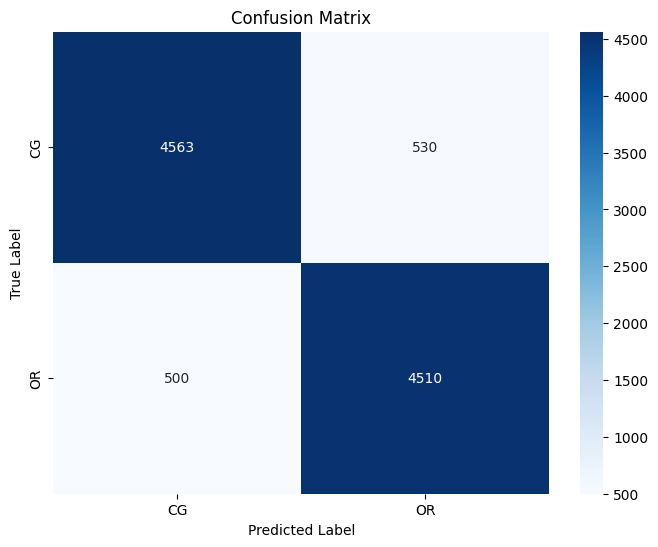

In [19]:

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred_tuned, labels=target_names)


N:\worktry\fake_reviews_detection\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
N:\worktry\fake_reviews_detection\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


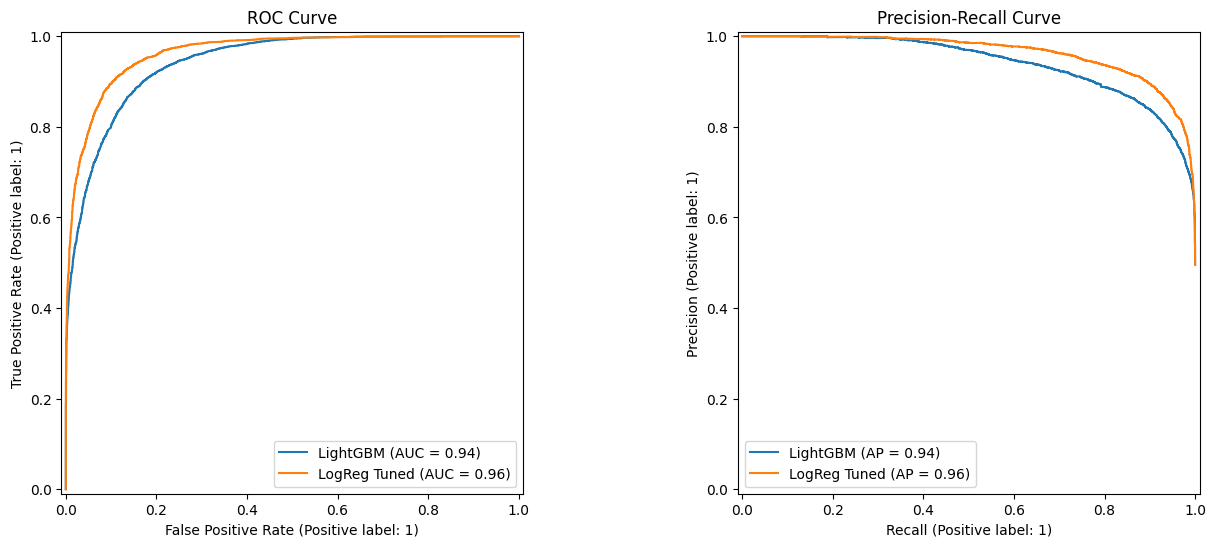

In [20]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

RocCurveDisplay.from_estimator(lgbm_model, X_test_vectorized, y_test, name='LightGBM', ax=ax1)
RocCurveDisplay.from_estimator(best_model, X_test_vectorized, y_test, name='LogReg Tuned', ax=ax1)

PrecisionRecallDisplay.from_estimator(lgbm_model, X_test_vectorized, y_test, name='LightGBM', ax=ax2)
PrecisionRecallDisplay.from_estimator(best_model, X_test_vectorized, y_test, name='LogReg Tuned', ax=ax2)

ax1.set_title("ROC Curve")
ax2.set_title("Precision-Recall Curve")
plt.show()

In [22]:
from source.visualization import Vizualizator

viz = Vizualizator(best_model, fitted_vectorizer, label_mapping)
viz.print_top_words()


--- Слова, наиболее связанные с классом 'fake' ---
reason gave         -11.722962
problem really      -10.637289
admit                -9.838715
bought friend        -9.646190
also love            -9.460722
downside             -9.440113
problem kind         -9.198448
material good        -8.504885
story start          -8.474835
plastic part         -8.153210
little hard          -8.004726
iti                  -7.908648
thing would          -7.843550
story told           -7.339901
keep review          -7.297953
love feel            -7.165109
reason               -7.047519
good enough          -6.911744
easy task            -6.641772
hard time            -6.559846
definitely buying    -6.513266
piece sturdy         -6.492284
starting get         -6.373432
big fan              -6.136618
get solid            -6.047799
also like            -6.040372
bought son           -6.033311
liked character      -6.019214
kind hard            -6.008454
fun game             -6.001645
dtype: float64

--

### Анализ качества моделей для определения фейковых отзывов

В рамках данного исследования были построены и оценены несколько моделей машинного обучения для задачи бинарной классификации текстовых отзывов на два класса: **CG** (Computer Generated - сгенерированные) и **OR** (Original Review - оригинальные).

Цель анализа — сравнить производительность моделей, оценить эффективность примененных техник (калибровка, подбор гиперпараметров, постобработка) и выбрать лучшую модель для решения задачи.

#### Сводная таблица результатов

Для наглядного сравнения сведем ключевые метрики всех протестированных моделей в одну таблицу. В качестве основной метрики для сравнения будем использовать `weighted F1-score`, так как она является гармоническим средним `precision` и `recall` и хорошо подходит для оценки наборов данных с небольшим дисбалансом (хотя в данном случае классы почти сбалансированы).

| Модель / Эксперимент | Accuracy | F1-score (weighted) | Precision (weighted) | Recall (weighted) |
|:------------------------------------------------|:----------:|:---------------------:|:----------------------:|:-------------------:|
| LightGBM (базовый) | 0.86 | 0.86 | 0.87 | 0.86 |
| LightGBM (калиброванный) | 0.86 | 0.86 | 0.86 | 0.86 |
| Logistic Regression (tuned, C=10) | **0.90** | **0.90** | **0.90** | **0.90** |
| Logistic Regression (с подбором порога) | **0.90** | **0.90** | **0.90** | **0.90** |

*Примечание: F1-score для LogReg с постобработкой увеличился с `0.8975` до `0.8991`, что в таблице округляется до `0.90`.*

---

### Детальный разбор моделей

#### 1. Модель LightGBM

Базовая модель градиентного бустинга `LightGBM` показала себя как сильный бейзлайн.
- **Accuracy = 0.86**
- **F1-score = 0.86**

Модель демонстрирует хорошее и сбалансированное качество для обоих классов, с небольшим превосходством `precision` для класса CG (`0.88`) и `recall` для класса OR (`0.88`). Это означает, что модель чуть реже ошибочно называет оригинальные отзывы сгенерированными, но при этом чуть чаще пропускает сгенерированные отзывы, считая их оригинальными.

**Эксперимент с калибровкой:**
Калибровка вероятностей с помощью `CalibratedClassifierCV` (метод `isotonic`) **не привела к изменению итоговых метрик классификации**. `Accuracy` и `F1-score` остались на том же уровне.

> **Вывод:** Это говорит о том, что либо исходные вероятности `LightGBM` были уже достаточно хорошо откалиброваны, либо изменение вероятностей было недостаточно сильным, чтобы сместить предсказания относительно порога 0.5. Хотя метрики не улучшились, сам эксперимент полезен, так как он подтверждает надежность предсказаний базовой модели.

#### 2. Модель Logistic Regression с подбором гиперпараметров

Логистическая регрессия после подбора параметра регуляризации `C` с помощью `GridSearchCV` показала **значительно лучшие результаты**.

- **Accuracy = 0.90**
- **F1-score = 0.90**

> **Вывод:** Рост качества на **4 процентных пункта** по сравнению с `LightGBM` является существенным. Модель демонстрирует практически идеальный баланс `precision` и `recall` для обоих классов (все метрики около `0.90`), что говорит о ее высокой надежности и робастности. Вероятно, для данной задачи с TF-IDF признаками более простая линейная модель с правильно подобранной регуляризацией (`C=10` означает слабую регуляризацию) оказалась более эффективной, чем сложная модель на основе деревьев, которая могла быть склонна к переобучению на некоторых признаках.

#### 3. Постобработка: Подбор оптимального порога для Logistic Regression

Для лучшей модели (Logistic Regression) была применена техника постобработки — поиск оптимального порога для максимизации F1-меры.
- Исходный F1-score (при пороге 0.5): **0.8975**
- Лучший F1-score (при пороге 0.4699): **0.8991**

> **Вывод:** Постобработка позволила получить небольшой, но все же заметный прирост в качестве. Снижение порога с 0.5 до ~0.47 означает, что мы стали относить к классу "фейковых" отзывы с чуть меньшей уверенностью. Это, как правило, немного повышает `recall` (полноту) за счет небольшого снижения `precision` (точности), и в данном случае этот компромисс привел к лучшему гармоническому среднему (F1-score).

---

### Общее заключение и рекомендации

**Победителем** в данном сравнении однозначно является модель **Logistic Regression с подобранным гиперпараметром `C=10` и последующей постобработкой предсказаний путем установки оптимального порога.**

Эта модель достигла **Accuracy и F1-score равных 0.90**, что является отличным результатом.

**Для дальнейшего углубленного анализа и подтверждения выводов рекомендуется:**

1.  **Построить матрицу ошибок (Confusion Matrix)** для лучшей модели, чтобы визуально оценить, сколько именно примеров каждого класса было классифицировано неверно.
2.  **Визуализировать ROC-кривую и Precision-Recall кривую**, чтобы сравнить модели на всей области порогов и убедиться в превосходстве логистической регрессии.
3.  **Провести анализ ошибок (Error Analysis)**: Вручную просмотреть ~10% тестовых примеров, на которых лучшая модель ошибается. Это может выявить системные проблемы (например, модель плохо справляется с короткими отзывами, сарказмом или сложными формулировками) и подсказать пути для дальнейшего улучшения, например, через создание новых признаков (Feature Engineering) или использование более сложных архитектур (трансформеров).